In [ ]:
import lgbm_pipeline.feature_load as loader
import lgbm_pipeline.feature_extraction as extractor
from lgbm_pipeline.feature_extraction import VITALS, LABS, DEMOGRAPHICS, DROPS, OUTCOME, FEATURES
import mgbm_pipeline.src.features.derive_features as derive

from tqdm import tqdm
import polars as pl
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score, make_scorer, classification_report, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.utils import shuffle
import xgboost as xgb

from main.pipelines_le.pipeline import find_project_root

In [ ]:
root = find_project_root()
patients: list[pl.DataFrame] = loader.load_data(f"{root}/training_set?/*.psv", max_files=None)

# Feature correlation

In [ ]:
# Get the correlation matrix
corr_matrix = pl.concat(patients).to_pandas().corr()
# Create a mask for correlations with abs value <= 0.5 or exactly 1.0
mask = (abs(corr_matrix) <= 0.5) | (abs(corr_matrix) >= 0.99999)
# Apply the mask (replacing filtered values with NaN)
filtered_corr = corr_matrix.mask(mask)
# Find columns that have at least one value in our desired range
has_correlations = (~filtered_corr.isnull()).sum() > 0
columns_to_keep = filtered_corr.columns[has_correlations]
# Keep only those columns/rows in the correlation matrix
reduced_corr = filtered_corr.loc[columns_to_keep, columns_to_keep]

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(14, 12))
sns.heatmap(
    reduced_corr,
    xticklabels=True,
    yticklabels=True,
    cmap="viridis",
    vmin=-1,
    vmax=1,
    center=0,
    square=True,
    annot=True,
    #mask=np.triu(reduced_corr), # keep lower triangle only
    linecolor="black",
    linewidths=0.25,
)

plt.title(f'{len(columns_to_keep)} most correlated features (0.5 < |PMCC| < 1.0)', fontsize=24)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(f"{root}/plots/correlation_matrix.png", format="png")
plt.show()

# Train/test split
Ensure enough sepsis patient representation in train and test sets

In [5]:
sepsis_patients: list[pl.DataFrame] = []
non_sepsis_patients: list[pl.DataFrame] = []

for patient in tqdm(patients, "Splitting sepsis/non-sepsis patients"):
	if patient.select(pl.any("SepsisLabel")).item():
		sepsis_patients.append(patient)
	else:
		non_sepsis_patients.append(patient)

Splitting sepsis/non-sepsis patients: 100%|██████████| 40336/40336 [00:00<00:00, 58829.45it/s]


In [6]:
train_sepsis_patients, test_sepsis_patients = train_test_split(sepsis_patients, random_state=42)
train_non_sepsis_patients, test_non_sepsis_patients = train_test_split(non_sepsis_patients, random_state=42)

In [7]:
ratio: float = len(train_non_sepsis_patients) / len(train_sepsis_patients)
print(f"Ratio: {ratio}")

train_patients: list[pl.DataFrame] = train_sepsis_patients + train_non_sepsis_patients
test_patients: list[pl.DataFrame] = test_sepsis_patients + test_non_sepsis_patients

print(f"Number of sepsis patients in training set: {len(train_sepsis_patients)}")
print(f"Number of non-sepsis patients in training set: {len(train_non_sepsis_patients)}")
print(f"Number of patients in training set: {len(train_patients)}\n")
print(f"Number of sepsis patients in testing set: {len(test_sepsis_patients)}")
print(f"Number of non-sepsis patients in testing set: {len(test_non_sepsis_patients)}")
print(f"Number of patients in testing set: {len(test_patients)}")

Ratio: 12.757162346521145
Number of sepsis patients in training set: 2199
Number of non-sepsis patients in training set: 28053
Number of patients in training set: 30252

Number of sepsis patients in testing set: 733
Number of non-sepsis patients in testing set: 9351
Number of patients in testing set: 10084


# Data imputation

In [8]:
train_patients_forward = extractor.fill(train_patients, extractor.FillMethod.FORWARD)
train_patients_backward = extractor.fill(train_patients, extractor.FillMethod.BACKWARD)
train_patients_linear = extractor.fill(train_patients, extractor.FillMethod.LINEAR)

Filling gaps in patient data: 100%|██████████| 30252/30252 [00:22<00:00, 1358.91it/s]


In [9]:
fill_to_list: dict[extractor.FillMethod, list[pl.DataFrame]] = {
	extractor.FillMethod.FORWARD : train_patients_forward,
	extractor.FillMethod.BACKWARD: train_patients_backward,
	extractor.FillMethod.LINEAR  : train_patients_linear,
    }

fill_to_concat: dict[extractor.FillMethod, pl.DataFrame] = {
	extractor.FillMethod.FORWARD : pl.concat(train_patients_forward, how="vertical"),
	extractor.FillMethod.BACKWARD: pl.concat(train_patients_backward, how="vertical"),
	extractor.FillMethod.LINEAR  : pl.concat(train_patients_linear, how="vertical"),
    }

fill_to_corr = {
	extractor.FillMethod.FORWARD : fill_to_concat[extractor.FillMethod.FORWARD].to_pandas().corr(),
	extractor.FillMethod.BACKWARD: fill_to_concat[extractor.FillMethod.BACKWARD].to_pandas().corr(),
	extractor.FillMethod.LINEAR  : fill_to_concat[extractor.FillMethod.LINEAR].to_pandas().corr(),
    }

In [10]:
fill_methods_to_use: dict[str, extractor.FillMethod] = extractor.best_fill_method_for_feature(fill_to_corr,FEATURES)
train_patients_mixed: list[pl.DataFrame] = extractor.mixed_fill(fill_to_list, fill_methods_to_use)

Performing mixed fill: 100%|██████████| 30252/30252 [00:31<00:00, 957.55it/s] 


In [11]:
test_patients_forward: list[pl.DataFrame] = extractor.fill(test_patients, extractor.FillMethod.FORWARD)
test_patients_backward: list[pl.DataFrame] = extractor.fill(test_patients, extractor.FillMethod.BACKWARD)
test_patients_linear: list[pl.DataFrame] = extractor.fill(test_patients, extractor.FillMethod.LINEAR)

fill_method_to_test_patients: dict[extractor.FillMethod, list[pl.DataFrame]] = {
	extractor.FillMethod.FORWARD : test_patients_forward,
	extractor.FillMethod.BACKWARD: test_patients_backward,
	extractor.FillMethod.LINEAR  : test_patients_linear,
    }

test_patients_mixed: list[pl.DataFrame] = extractor.mixed_fill(fill_method_to_test_patients, fill_methods_to_use)

Performing mixed fill: 100%|██████████| 10084/10084 [00:09<00:00, 1012.02it/s]


# Down sample non-sepsis patient data

In [12]:
mixed_sepsis = []
mixed_non_sepsis = []

for patient in tqdm(train_patients_mixed, "Splitting sepsis/non-sepsis patients"):
	if patient.select(pl.any("SepsisLabel")).item():
		mixed_sepsis.append(patient)
	else:
		mixed_non_sepsis.append(patient)

mixed_non_sepsis = shuffle(mixed_non_sepsis, random_state=42, n_samples=2*len(mixed_sepsis))
final_train = mixed_non_sepsis + mixed_sepsis

Splitting sepsis/non-sepsis patients: 100%|██████████| 30252/30252 [00:00<00:00, 51238.80it/s]


In [13]:
train = derive.compute_derived_features_polars(pl.concat(final_train, how="vertical"))
test = derive.compute_derived_features_polars(pl.concat(test_patients_mixed, how="vertical"))

In [14]:
train.head()

HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,FiO2,pH,PaCO2,SaO2,AST,BUN,Alkalinephos,Calcium,Chloride,Creatinine,Bilirubin_direct,Glucose,Lactate,Magnesium,Phosphate,Potassium,Bilirubin_total,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Age,Gender,SepsisLabel,ShockIndex,AgeNormalisedShockIndex,ModifiedShockIndex,UCR,SaO2_FiO2,PulsePressure,CardiacOutput,PartialSOFA,qSOFA
f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,bool,bool,f32,f32,f32,f32,f32,f32,f32,f32,f32
145.0,94.0,37.0,107.0,80.330002,null,24.0,null,null,22.0,null,null,null,null,null,15.0,null,7.8,117.0,0.5,null,79.0,null,1.7,null,2.7,null,null,25.9,8.2,30.6,20.1,522.0,138.0,62.240002,true,false,1.35514,0.021773,0.029002,30.0,null,null,null,1.0,1.0
145.0,94.0,37.0,107.0,80.330002,null,24.0,null,null,22.0,null,null,null,null,null,15.0,null,7.8,117.0,0.5,null,79.0,null,1.7,null,2.7,null,null,25.9,8.2,30.6,20.1,522.0,138.0,62.240002,true,false,1.35514,0.021773,0.029002,30.0,null,null,null,1.0,1.0
139.0,96.0,37.0,106.0,78.669998,null,23.666666,null,null,22.0,null,null,null,null,null,15.0,null,7.8,117.0,0.5,null,79.0,null,1.7,null,2.7,null,null,25.9,8.2,30.6,20.1,522.0,138.0,62.240002,true,false,1.311321,0.021069,0.028388,30.0,null,null,null,1.0,1.0
115.0,96.5,36.110001,94.5,68.830002,null,23.333334,null,null,22.0,null,null,null,null,null,15.0,null,7.8,117.0,0.5,null,79.0,null,1.7,null,2.7,null,null,25.9,8.2,30.6,20.1,522.0,138.0,62.240002,true,false,1.216931,0.019552,0.026844,30.0,null,null,null,2.0,2.0
110.0,95.75,36.110001,101.25,72.75,null,23.0,null,null,22.0,null,null,null,null,null,15.0,null,7.8,117.0,0.5,null,79.0,null,1.7,null,2.7,null,null,25.9,8.2,30.6,20.1,522.0,138.0,62.240002,true,false,1.08642,0.017455,0.024294,30.0,null,null,null,1.0,1.0


In [15]:
X_train = train.drop("SepsisLabel")
y_train = train.select("SepsisLabel").to_series()
X_test = test.drop("SepsisLabel")
y_test = test.select("SepsisLabel").to_series()

In [26]:
f = make_scorer(fbeta_score, beta=1)

clf = xgb.XGBClassifier(objective="binary:logistic", eval_metric=f, scale_pos_weight=ratio)
bst = clf.fit(X_train, y_train)

In [27]:
y_pred = bst.predict(X_test)

              precision    recall  f1-score   support

       False       0.99      0.90      0.94    380826
        True       0.06      0.37      0.11      7017

    accuracy                           0.89    387843
   macro avg       0.52      0.63      0.52    387843
weighted avg       0.97      0.89      0.92    387843



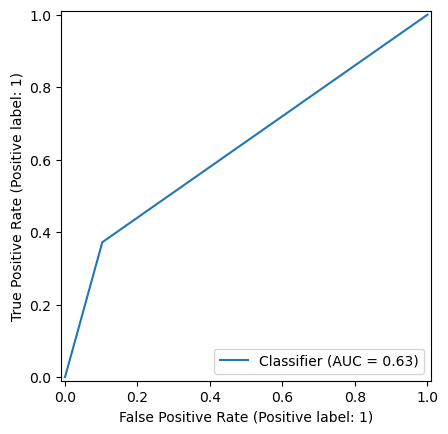

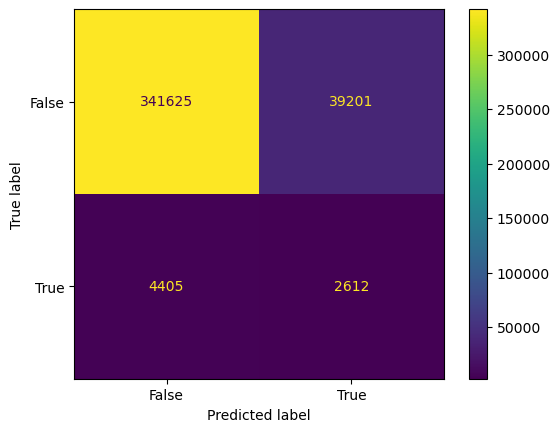

In [28]:
RocCurveDisplay.from_predictions(y_test, y_pred)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
print(classification_report(y_test, y_pred))